In [1]:
import sys
sys.path.append('..')
import dynasim

import numpy as np
from math import pi

import findiff

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = np.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w(x,t)}{\partial t^2} + E I \frac{\partial^4w(x,t)}{\partial x^4} + \rho A c \frac{\partial w(x,t)}{\partial t} = f(x,t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)q_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)q_j(t) $$
where $\varphi_j$ and $q_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \mathbf{q}(t) \\ \dot{\mathbf{q}}(t) \end{bmatrix}, \qquad
\mathbf{q}(t) = \left[ q_1(t), q_2(t), ..., q_n(t) \right]^T, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{q}(t) \\ \ddot{\mathbf{q}}(t) \end{bmatrix} $$

Material parameters

In [3]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (12*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

c = 0.05
l = 1.0

E = 1e7  # Young's modulus
rho = 2700  # density
EI = 5e-3  # flexural rigidity Nm^2
pA = 1.0  # mass per unit

mu = 1.0

area = pA / rho
w1 = (pi**2) * ((EI)/(pA*(l**4)))**0.5
f1 = w1/(2*pi)
I, area, b, h = gen_beam_params(E, rho, EI, pA)
mass = rho * (area * l)

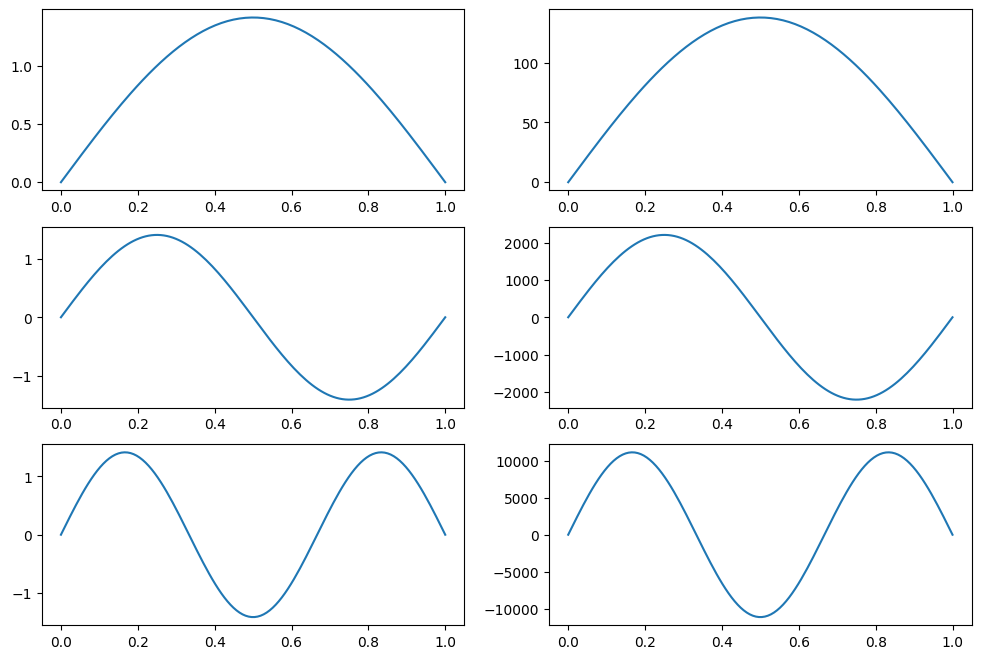

In [4]:
nt = 1024
nx = 128
n_modes = 3

# material_props_full = {
#     "E" : E,
#     "I" : I,
#     "rho" : rho,
#     "area" : area,
#     "c" : c,
#     "l" : l
# }
# ss_beam = dynasim.systems.cont_beam("full_vars", **material_props_full)

beam_kwargs_cmb = {
    "EI" : EI,
    "pA" : pA,
    "c" : c,
    "l" : l
}
ss_beam = dynasim.systems.cont_beam("cmb_vars", **beam_kwargs_cmb)

# material_props_uni = {
#     "mu" : mu,
#     "c" : c,
#     "l" : l
# }
# ss_beam = dynasim.systems.cont_beam("uni_vars", **material_props_uni)

xx, phis = ss_beam.gen_modes("ss-ss", n_modes, nx)
phis_dx4 = ss_beam.phi_dx4_n

fig, axs = plt.subplots(n_modes, 2, figsize=(12, 8))
for i in range(n_modes):
    axs[i,0].plot(xx, phis[:,i])
    axs[i,1].plot(xx, phis_dx4[:,i])

Initial displacement/forcing

In [7]:
init_disp = 0.1
w0_func = lambda x : init_disp * (np.sin(pi*x)+np.sin(2*pi*x)+np.sin(3*pi*x))
w0 = w0_func(ss_beam.xx)
q0 = init_disp * np.ones((n_modes))
# q0 = init_disp * np.array([1, 1, 1])
qd0 = np.zeros((n_modes))
tau0 = np.concatenate((q0, qd0), axis=0)

ss_beam.excitations = [None] * n_modes

tt = np.linspace(0, 20, nt)
data = ss_beam.simulate(tt, z0 = tau0)

qq, qqd = data['x'], data['xdot']

ww = np.sum(np.matmul(qq[:,:,np.newaxis], phis.T[:,np.newaxis,:]), axis=0)
wwd = np.sum(np.matmul(qqd[:,:,np.newaxis], phis.T[:,np.newaxis,:]), axis=0)

for i in range(n_modes):
    print('Natural frequency {:d}: {:4f} rad/s --- {:4f} Hz'.format(i+1, ss_beam.wn[i], ss_beam.wn[i]/(2*pi)))

Natural frequency 1: 0.697886 rad/s --- 0.111072 Hz
Natural frequency 2: 2.791546 rad/s --- 0.444288 Hz
Natural frequency 3: 6.280978 rad/s --- 0.999649 Hz


Finite difference to check state values

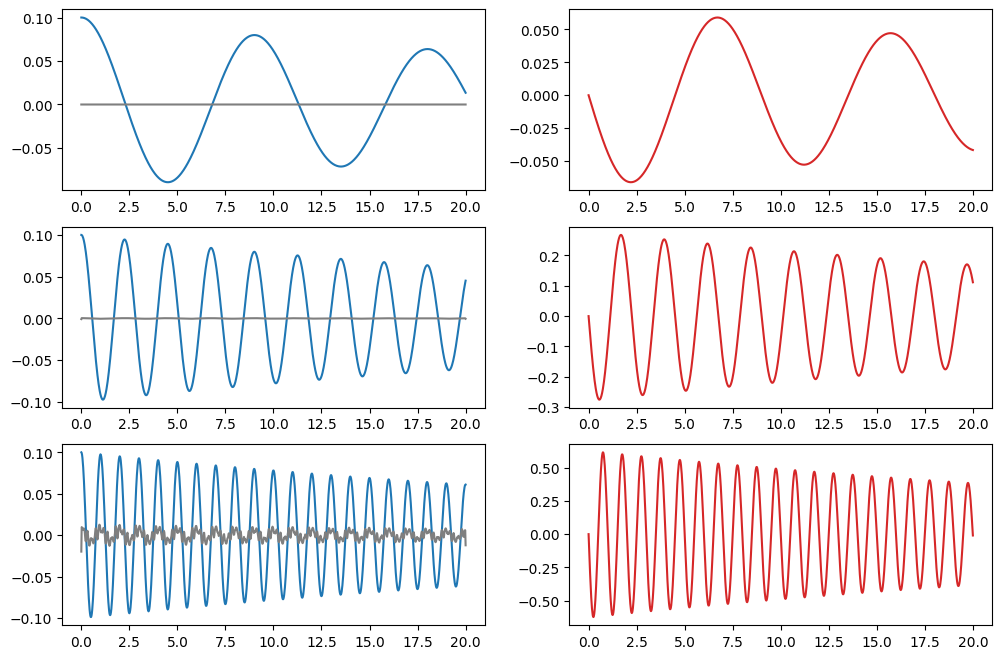

In [8]:
dt = tt[1] - tt[0]
d_dt = findiff.FinDiff(0, dt)
qqdd = d_dt(qqd.T).T

tau_gt = np.concatenate((qq,qqd), axis=0)
taud_gt = np.concatenate((qqd, qqdd), axis=0)

M, C, K = ss_beam.M, ss_beam.C, ss_beam.K
A = np.concatenate((
    np.concatenate((np.zeros((n_modes, n_modes)),np.eye(n_modes)), axis=1),
    np.concatenate((-np.linalg.inv(M)@K, -np.linalg.inv(M)@C), axis=1)
    ), axis=0)
H = np.concatenate((np.zeros((n_modes, n_modes)),np.linalg.inv(M)), axis=0)

R_check = (taud_gt - A @ tau_gt)[n_modes:]

fig, axs = plt.subplots(n_modes, 2, figsize=(12, 8))
for i in range(n_modes):
    axs[i,0].plot(tt, qq[i,:], 'tab:blue')
    axs[i,0].plot(tt, R_check[i,:], 'tab:gray')
    axs[i,1].plot(tt, qqd[i,:], 'tab:red')

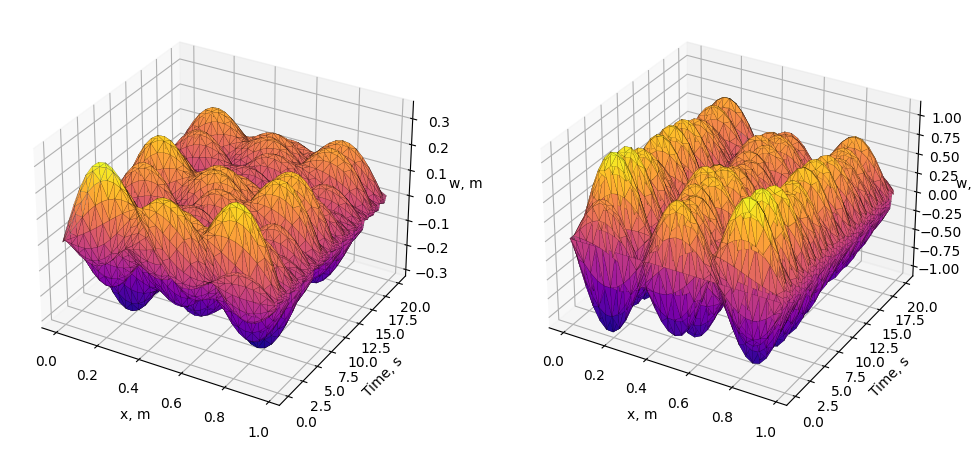

In [10]:
def plot_vib_surface(ax, x, t_span, w, sub_samp=10):
    if len(x.shape) == 1 and len(t_span.shape) == 1:
        xx, tt = np.meshgrid(x[::sub_samp], t_span[::sub_samp])
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and t_span.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(t_span[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and t_span.shape[1] <= 1:
            xx, tt = np.meshgrid(x[::sub_samp], t_span[::sub_samp])
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')
    # ax.view_init(90, -90, 0)

fig, axs = plt.subplots(1, 2, subplot_kw = {"projection":"3d"}, figsize = (12, 8))
plot_vib_surface(axs[0], xx, tt, ww, 4)
# plot_vib_surface(axs[1], xx, tt, ww_, 4)
plot_vib_surface(axs[1], xx, tt, wwd, 4)